In [7]:
# handling data
import numpy as np
import pandas as pd

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, s, l

# handling telomere length data
import fukushima_telomere_methods as f_tm

# for loading telo data column containing individual
# telomere length values, enables literal reading of a list as numbers
from ast import literal_eval

# setting all graphs to have darkgrid style w/ black edges for axes elements
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

# incase module requires reloading
import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
&nbsp; 

...

&nbsp; 

---

# Mean Telomere Length and Dose
---

In [167]:
# Loading New Dose Quantifications (+age/sex data), Cortisol, Telomere FISH, and Dicentric Data

In [15]:
kelly_boar_dose = pd.read_csv('../excel data/cleaned/kelly_boar_dose.csv')
kelly_boar_teloFISH_df = pd.read_csv('../excel data/cleaned/kelly_boar_teloFISH_df.csv')
kelly_boar_teloFISH_df['teloFISH data'] = kelly_boar_teloFISH_df['teloFISH data'].apply(lambda row: np.array(literal_eval(row)))

## Merging Kelly's Telomere FISH data w/ New Dose Quantifications (+age/sex data)

In [169]:
# general cols of interest
general_cols_of_interest = ['Sample ID', 'Sex', 'Age (months)', 
                            'INTERNAL Life time dose, mGy 134+137',
                            'EXTERNAL Dose Reasonable Life Time, mGy (134+137)',
                            'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
                            'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)'
                           ]

In [170]:
merge_kelly_teloFISH_dose = kelly_boar_teloFISH_df.merge(kelly_boar_dose, on=['Sample ID'])

teloFISH_cols = general_cols_of_interest + ['teloFISH means']

# selecting cols of interest 
merge_kelly_teloFISH_dose = merge_kelly_teloFISH_dose[teloFISH_cols].copy()

In [171]:
merge_kelly_teloFISH_dose.rename(columns={'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                                          'Dose rate (uGy per h)',
                                          'teloFISH means': 'Mean Telomere Length (FISH)'}, inplace=True)

merge_kelly_teloFISH_dose['encode sex'] = merge_kelly_teloFISH_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))
f_tm.enforce_col_types(merge_kelly_teloFISH_dose)

In [172]:
# saving for final writeup
merge_kelly_teloFISH_dose.to_csv('../excel data/cleaned/merge_kelly_teloFISH_dose.csv', index=False)

## Visualizing Mean Telomere Length vs. Dose

In [173]:
dose_types = ['INTERNAL Life time dose, mGy 134+137',
              'EXTERNAL Dose Reasonable Life Time, mGy (134+137)',
              'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
              'Dose rate (uGy per h)']

In [84]:
x2 = ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)']

X_r = merge_kelly_teloFISH_dose[x2].values.reshape(-1, 2)
y_r = merge_kelly_teloFISH_dose[y].values.reshape(-1, 1)
fit_lm = LinearRegression().fit(X_r,y_r)
        
y_pred = fit_lm.predict(X_r)
y_pred = pd.DataFrame(y_pred, columns=['telo pred'])

Performing a multivariate linear regression between dose/age vs. telomere length, then storing the fitted models predictions of telomere length as 'y_pred'.. seeing how 'y_pred' looks plotted below

(array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 <a list of 8 Text yticklabel objects>)

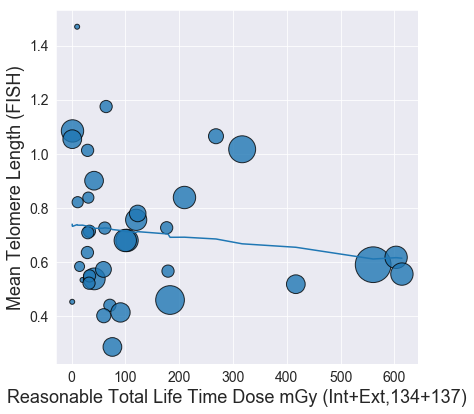

In [88]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
y = 'Mean Telomere Length (FISH)'

fig, ax = plt.subplots(figsize=(6.5,6.5))
sns.scatterplot(x=x, y=y, s=merge_kelly_teloFISH_dose['Age (months)'] * 25, alpha=0.8, 
                     data=merge_kelly_teloFISH_dose, 
                     linewidth=1,
                     edgecolor='black', ax=ax
                    )
# plt.plot(merge_kelly_teloFISH_dose[x], y_pred['pred'], linewidth=1, )
sns.lineplot(x=merge_kelly_teloFISH_dose[x], y=y_pred['telo pred'], ax=ax)

# plt.suptitle(f'{x} vs.\n {y} in Fukushima Wild Boar', fontsize=18)
# # plt.subplots_adjust(top=.85)

plt.xlabel(x, fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel(y, fontsize=18)
plt.yticks(fontsize=14)

In [150]:
merge_kelly_teloFISH_dose['Age class'] = 'temp'

def make_age_class(row):
    if row <= 12:
        return 'piglet'
    elif row > 12 and row < 24:
        return 'yearling'
    elif row >= 20:
        return 'adult'
    
merge_kelly_teloFISH_dose['Age class'] = merge_kelly_teloFISH_dose['Age (months)'].apply(lambda row: make_age_class(row))

In [151]:
merge_kelly_teloFISH_dose.head(2)

,Sample ID,Sex,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Mean Telomere Length (FISH),encode sex,Age class,Age Class
0,1606103,Male,6,2.756694,68.208,70.964694,3.554446,0.439557,1,piglet,piglet
1,1607205,Male,1,0.034633,0.882,0.916633,0.727816,0.452469,1,piglet,piglet


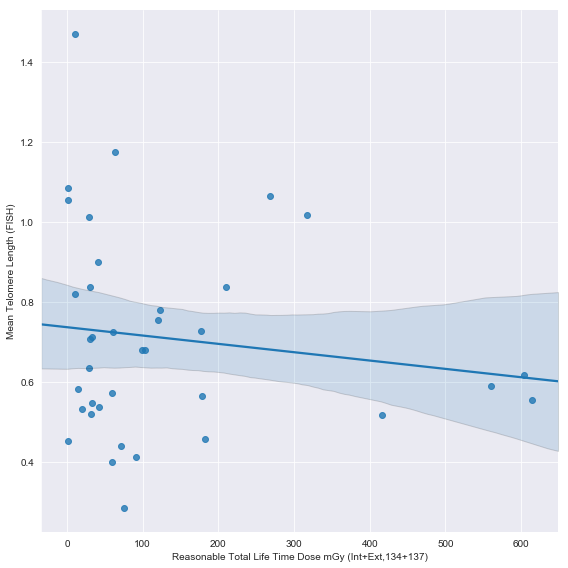

In [144]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
y = 'Mean Telomere Length (FISH)'

sns.lmplot(x=x, y=y, data=merge_kelly_teloFISH_dose, height=8, aspect=1,
#           x_partial='Age (months)',
          )

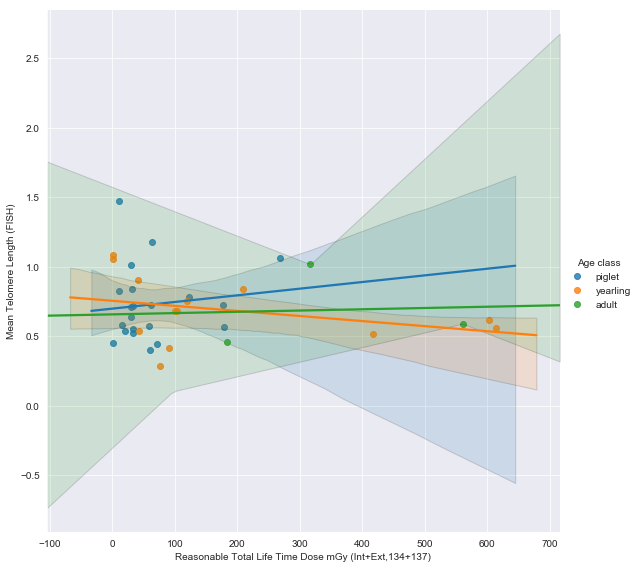

In [166]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
y = 'Mean Telomere Length (FISH)'

ax = sns.lmplot(x=x, y=y, data=merge_kelly_teloFISH_dose, height=8, aspect=1, hue='Age class',
#           robust=True,
               )

Really no difference compared to below.. i think no point pursuing this..

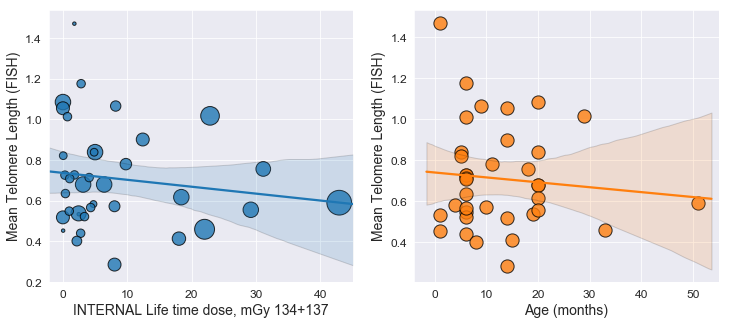

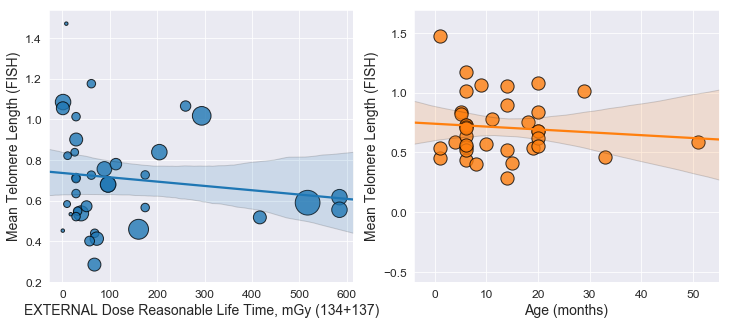

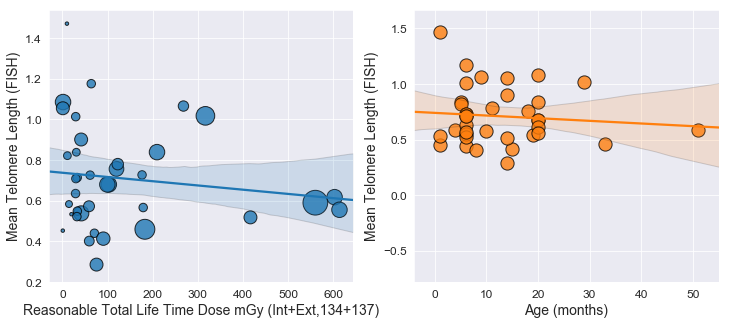

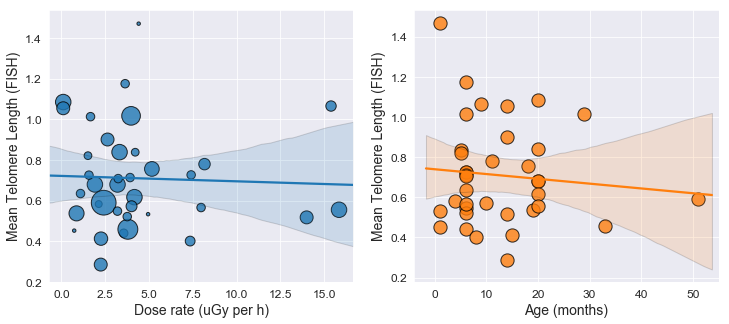

In [89]:
x2 = 'Age (months)'
y = 'Mean Telomere Length (FISH)'

for col in dose_types:
    f_tm.graph_dose_age_vs_telos(df=merge_kelly_teloFISH_dose, x=col, x2=x2, y=y)

## Statistics

In [174]:
merge_kelly_teloFISH_dose['encoded sex'] = merge_kelly_teloFISH_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))

In [175]:
y = merge_kelly_teloFISH_dose['Mean Telomere Length (FISH)'].values.reshape(-1, 1)
y_name = 'teloFISH means'

f_tm.linear_regression_scores_X_y(merge_kelly_teloFISH_dose, y, y_name, dose_types)

OLS | ['INTERNAL Life time dose, mGy 134+137'] vs. teloFISH means --> R2: 0.0190
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)'] vs. teloFISH means --> R2: 0.0193
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)', 'encoded sex'] vs. teloFISH means --> R2: 0.0413

OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)'] vs. teloFISH means --> R2: 0.0183
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)'] vs. teloFISH means --> R2: 0.0187
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)', 'encoded sex'] vs. teloFISH means --> R2: 0.0421

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. teloFISH means --> R2: 0.0191
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. teloFISH means --> R2: 0.0193
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. teloFISH means --> R2: 0.0436

OLS | ['Dose rate (uGy per h)'] vs. t

In [60]:
merge_kelly_teloFISH_dose.groupby(['Sex', 'encode sex']).agg('mean')

,,Age (months),"INTERNAL Life time dose, mGy 134+137","EXTERNAL Dose Reasonable Life Time, mGy (134+137)","Reasonable Total Life Time Dose mGy (Int+Ext,134+137)",Dose rate (uGy per h),Mean Telomere Length (FISH)
Sex,encode sex,,,,,,
Female,0,15.588235,12.427713,200.955859,213.383571,5.683106,0.729855
Male,1,9.850000,3.769760,55.551300,59.321060,3.159496,0.693017


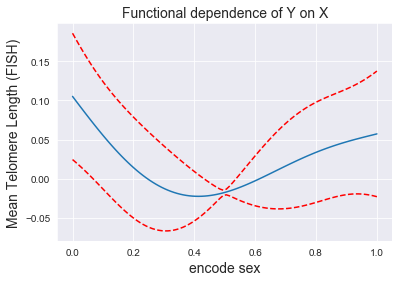

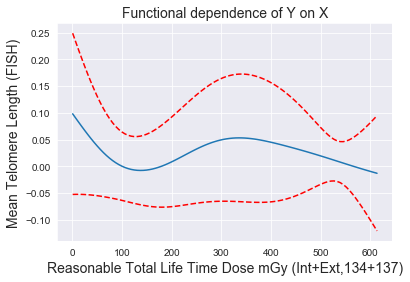

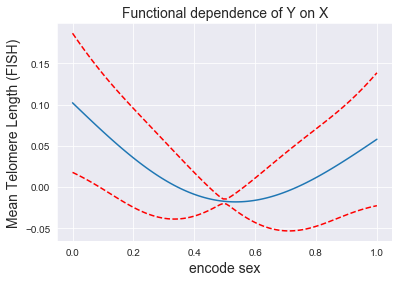

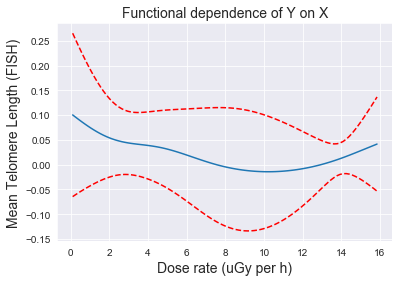

In [55]:
for dose in ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
             'Dose rate (uGy per h)']:
    
    features = [
#         'Age (months)', 
                'encode sex'
               ]
    features += [dose]
    target = 'Mean Telomere Length (FISH)'
    f_tm.fit_gam_plot_dependencies(df=merge_kelly_teloFISH_dose, features=features, target=target,
                              basis_1=s, basis_2=s, summary=False)

# Cortisol and Dose
---

In [79]:
prep_boar_cortisol_df = pd.read_csv('../excel data/cleaned/prep_boar_cortisol_df.csv')
aryn_boar_dose = pd.read_csv('../excel data/cleaned/aryn_boar_dose.csv')

# renaming for consistency between cols
aryn_boar_dose.rename(columns={'Dose rate (uGy/h) at time of capture (Int+Ext; 134+137)':
                               'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)'}, inplace=True)

In [80]:
# combining data
dose_cort_cols_interest = general_cols_of_interest + ['Cortisol (pg/mg)']

trim_kelly_dose_cortisol = f_tm.merge_return_df_cols_interest(kelly_boar_dose, prep_boar_cortisol_df, dose_cort_cols_interest)
trim_aryn_dose_cortisol = f_tm.merge_return_df_cols_interest(aryn_boar_dose, prep_boar_cortisol_df, dose_cort_cols_interest)
total_dose_cortisol = pd.concat([trim_kelly_dose_cortisol, trim_aryn_dose_cortisol], axis=0).reset_index(drop=True)

In [81]:
# renaming col & enforcing col types
total_dose_cortisol.rename(columns={'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                                    'Dose rate (uGy per h)'}, inplace=True)

f_tm.enforce_col_types(total_dose_cortisol)

In [82]:
# saving for final writeup
total_dose_cortisol.to_csv('../excel data/cleaned/total_dose_cortisol.csv', index=False)

## Visualizing Cortisol vs. Dose

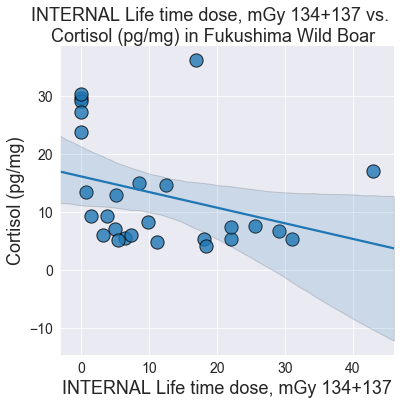

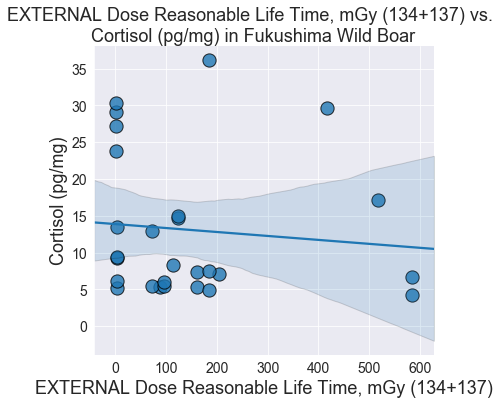

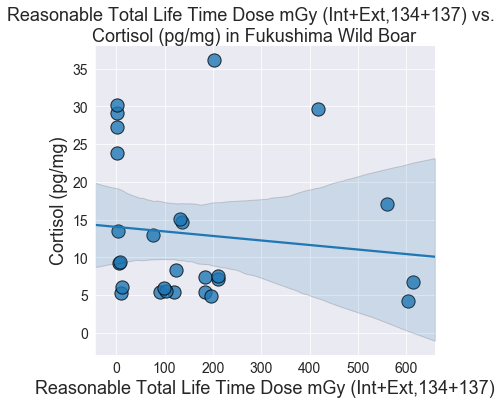

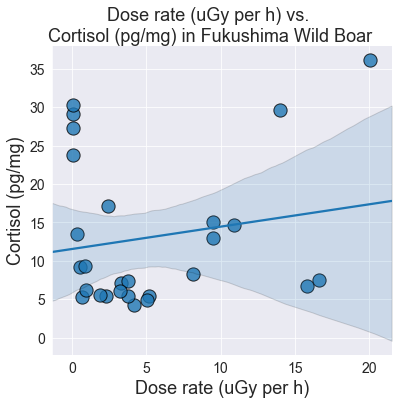

In [19]:
for col in dose_types:
    f_tm.linear_regression_graphs_between_variables(x=col, y='Cortisol (pg/mg)', data=total_dose_cortisol)

## Statistics

In [89]:
total_dose_cortisol['encoded sex'] = total_dose_cortisol['Sex'].apply(lambda row: f_tm.encode_sex(row))

In [90]:
y = total_dose_cortisol['Cortisol (pg/mg)'].values.reshape(-1, 1)
y_name = 'Cortisol (pg/mg)'

f_tm.linear_regression_scores_X_y(total_dose_cortisol, y, y_name, dose_types)

OLS | ['INTERNAL Life time dose, mGy 134+137'] vs. Cortisol (pg/mg) --> R2: 0.1013
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)'] vs. Cortisol (pg/mg) --> R2: 0.1587
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)', 'encoded sex'] vs. Cortisol (pg/mg) --> R2: 0.1636

OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)'] vs. Cortisol (pg/mg) --> R2: 0.0096
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)'] vs. Cortisol (pg/mg) --> R2: 0.0098
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)', 'encoded sex'] vs. Cortisol (pg/mg) --> R2: 0.0104

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. Cortisol (pg/mg) --> R2: 0.0130
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. Cortisol (pg/mg) --> R2: 0.0136
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. Cortisol (pg/mg) --> R2: 0.0146

OLS | ['Dose rate (

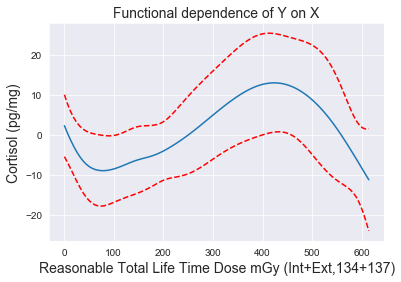

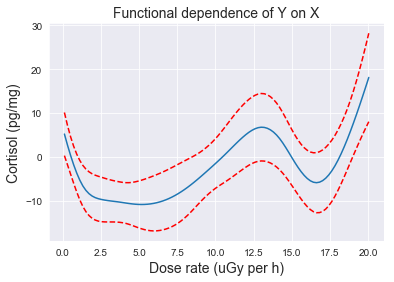

In [97]:
for dose in ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 
             'Dose rate (uGy per h)']:
    
    features = []
    features += [dose]
    target = 'Cortisol (pg/mg)'
    f_tm.fit_gam_plot_dependencies(df=total_dose_cortisol, features=features, target=target,
                              basis_1=s, summary=False)

# Aryn Data (telomere length qPCR)

## Boar qPCR data

In [24]:
aryn_boar_df = pd.read_csv('../excel data/cleaned/aryn_boar_df.csv')
aryn_boar_df.drop(['Sex'], axis=1, inplace=True)

In [25]:
qPCR_cols_interest = general_cols_of_interest + ['Normalized T/A Average (Average Telomere Length)']

#aryn_boar_dose is loaded above in the cortisol section
aryn_qPCR_dose = f_tm.merge_return_df_cols_interest(aryn_boar_dose, aryn_boar_df, qPCR_cols_interest)
aryn_qPCR_dose.replace(to_replace=' ', value=np.NaN, inplace=True)
aryn_qPCR_dose.dropna(axis=0, inplace=True)
aryn_qPCR_dose.rename(columns={'Normalized T/A Average (Average Telomere Length)': 
                               'Mean Telomere Length (qPCR)',
                               'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                               'Dose rate (uGy per h)'}, inplace=True)

f_tm.enforce_col_types(aryn_qPCR_dose)

NameError: name 'general_cols_of_interest' is not defined

In [100]:
# saving for final writeup
aryn_qPCR_dose.to_csv('../excel data/cleaned/aryn_boar_qPCR_dose.csv', index=False)

### Visualizing Mean Telomere Length vs. Dose

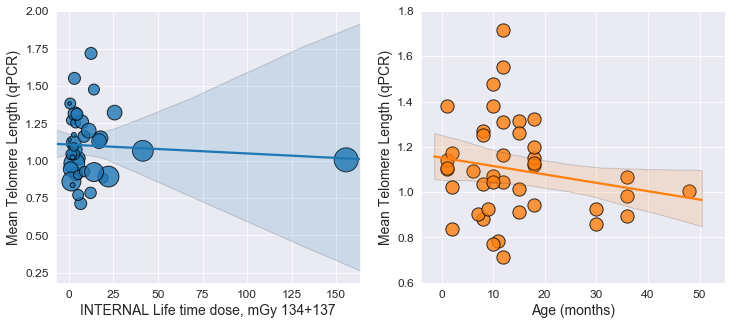

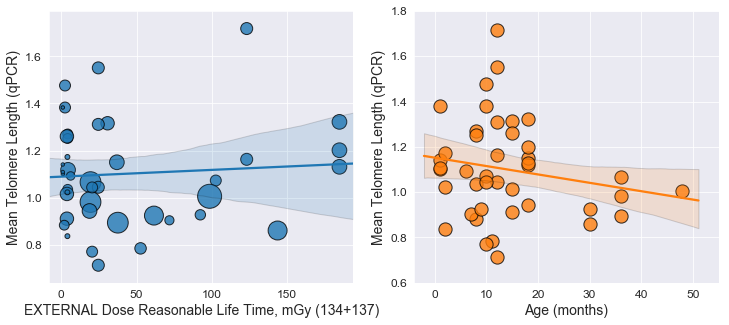

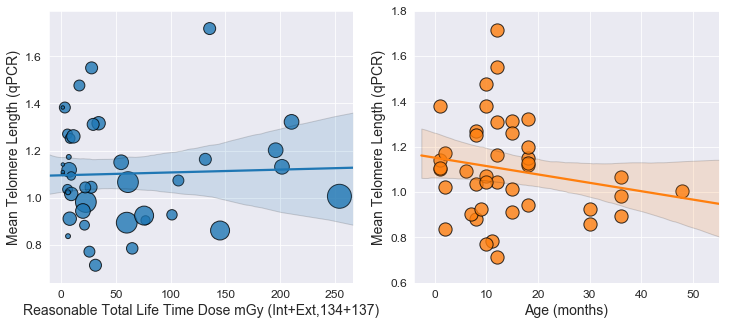

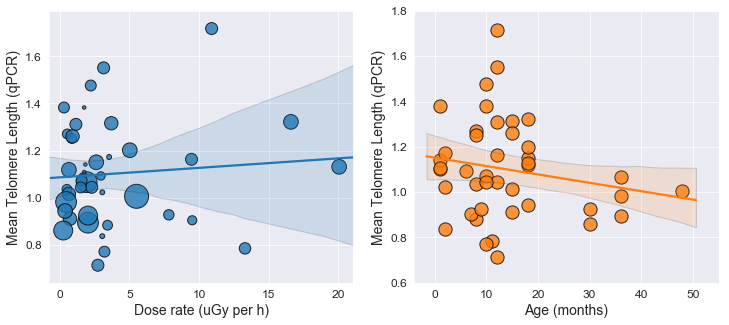

In [42]:
x2 = 'Age (months)'
y = 'Mean Telomere Length (qPCR)'

for col in dose_types:
    f_tm.graph_dose_age_vs_telos(df=aryn_qPCR_dose, x=col, x2=x2, y=y)

### Statistics

In [101]:
aryn_qPCR_dose['encoded sex'] = aryn_qPCR_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))

In [102]:
y = aryn_qPCR_dose['Mean Telomere Length (qPCR)'].values.reshape(-1, 1)
y_name = 'Mean Telos (qPCR)'

f_tm.linear_regression_scores_X_y(aryn_qPCR_dose, y, y_name, dose_types)

OLS | ['INTERNAL Life time dose, mGy 134+137'] vs. Mean Telos (qPCR) --> R2: 0.0045
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)'] vs. Mean Telos (qPCR) --> R2: 0.0380
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)', 'encoded sex'] vs. Mean Telos (qPCR) --> R2: 0.0443

OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)'] vs. Mean Telos (qPCR) --> R2: 0.0054
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)'] vs. Mean Telos (qPCR) --> R2: 0.0549
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)', 'encoded sex'] vs. Mean Telos (qPCR) --> R2: 0.0594

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. Mean Telos (qPCR) --> R2: 0.0014
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. Mean Telos (qPCR) --> R2: 0.0579
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. Mean Telos (qPCR) --> R2: 0.0632

OLS | ['Do

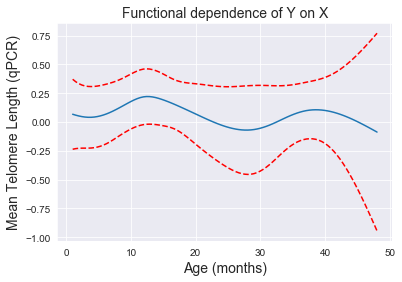

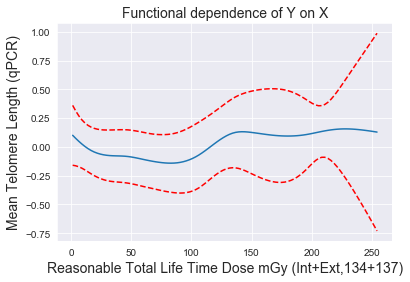

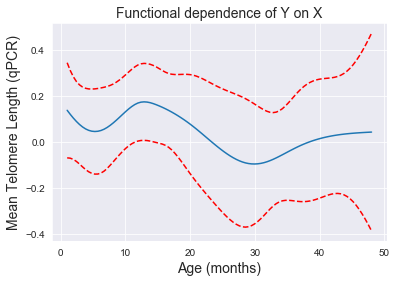

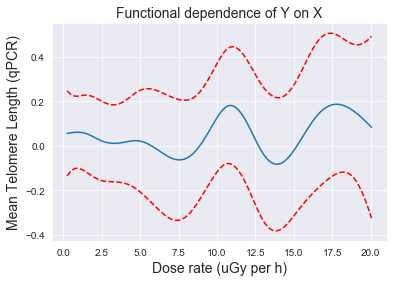

In [105]:
for dose in ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
             'Dose rate (uGy per h)']:
    
    features = ['Age (months)']
    features += [dose]
    target = 'Mean Telomere Length (qPCR)'
    f_tm.fit_gam_plot_dependencies(df=aryn_qPCR_dose, features=features, target=target,
                              basis_1=s, basis_2=s, summary=False)

## Snake qPCR data

In [3]:
aryn_snake_df = pd.read_csv('../excel data/cleaned/aryn_snake_df.csv')
aryn_snake_df.drop(10, axis=0, inplace=True)
# aryn_snake_df


aryn_snake_df['Sex'] = aryn_snake_df['Sex'].apply(lambda row: f_tm.male_or_female(row))
aryn_snake_df['encode sex'] = aryn_snake_df['Sex'].apply(lambda row: f_tm.encode_sex(row))
aryn_snake_df.rename(columns={'Telomere Length (qPCR)': 'Mean Telomere Length (qPCR)'}, inplace=True)

In [4]:
# saving for later writeup
aryn_snake_df.to_csv('../excel data/cleaned/aryn_snake_df.csv', index=False)

### Visualizing Mean Telomere Length vs. Dose rate

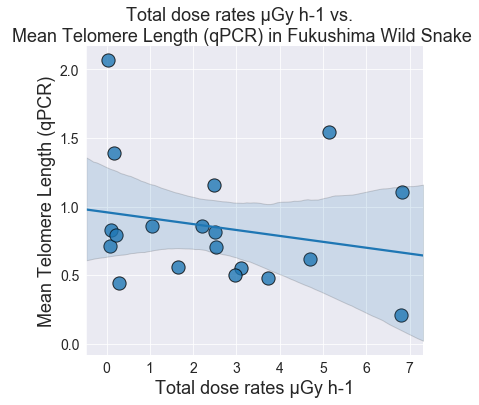

In [8]:
f_tm.linear_regression_graphs_between_variables(x='Total dose rates μGy h-1', y='Mean Telomere Length (qPCR)',
                                                data=aryn_snake_df, snake=True)

### Statistics

In [9]:
features_list = [['Total dose rates μGy h-1'], ['Total dose rates μGy h-1', 'encode sex']]

for features in features_list:
#     if 'encode sex' in features:
#         aryn_snake_df.dropna(axis=0, inplace=True)
    y = aryn_snake_df['Mean Telomere Length (qPCR)'].values.reshape(-1, 1)
    X = aryn_snake_df[features].values.reshape(-1, len(features))
    fit_lm = LinearRegression().fit(X, y)
    
    print(f'OLS | {features} vs. Mean Telomere Length (qPCR) --> R2: {fit_lm.score(X, y):.4f}')

OLS | ['Total dose rates μGy h-1'] vs. Mean Telomere Length (qPCR) --> R2: 0.0457
OLS | ['Total dose rates μGy h-1', 'encode sex'] vs. Mean Telomere Length (qPCR) --> R2: 0.1081


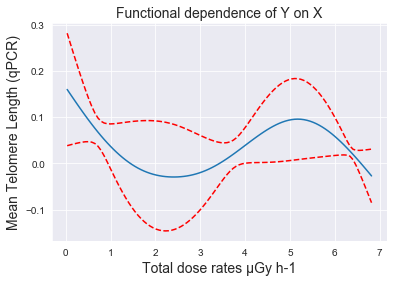

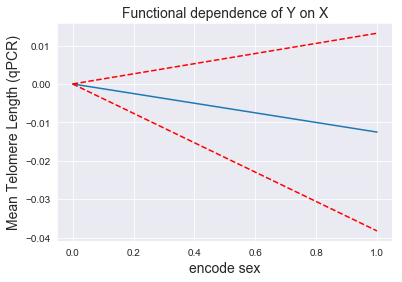

In [13]:
features = ['Total dose rates μGy h-1', 'encode sex']
target = 'Mean Telomere Length (qPCR)'
f_tm.fit_gam_plot_dependencies(df=aryn_snake_df, features=features, target=target,
                          basis_1=s, basis_2=l, summary=False)

# Dicentrics and Dose

In [144]:
kelly_boar_dicentrics_df = pd.read_csv('../excel data/cleaned/kelly_boar_dicentrics_df.csv')

In [145]:
dicentrics_cols = general_cols_of_interest + ['Average Dicentrics per cell']
merge_dicentrics_dose = f_tm.merge_return_df_cols_interest(kelly_boar_dose, kelly_boar_dicentrics_df, dicentrics_cols)

merge_dicentrics_dose.rename(columns={'Dose rate (uGy/h, not lifetime) at time of capture (Int+Ext; 134+137)': 
                                      'Dose rate (uGy per h)'}, inplace=True)

In [146]:
# saving for later writeup
merge_dicentrics_dose.to_csv('../excel data/cleaned/merge_dicentrics_dose.csv', index=False)

## Visualizing Dicentrics vs. Dose

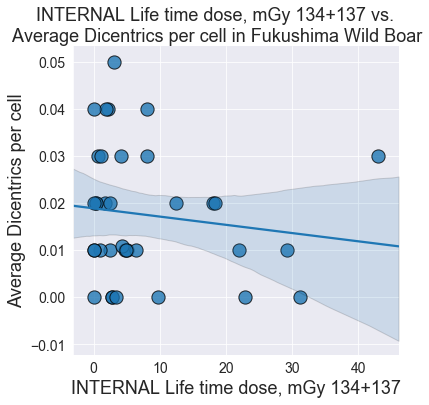

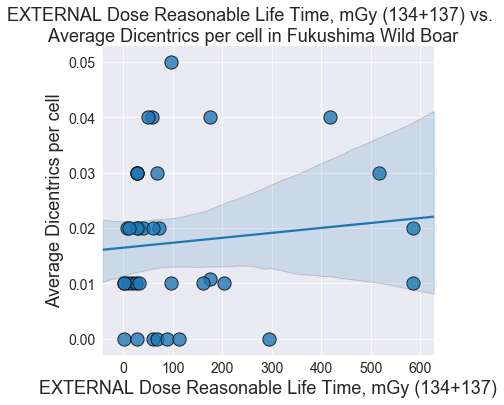

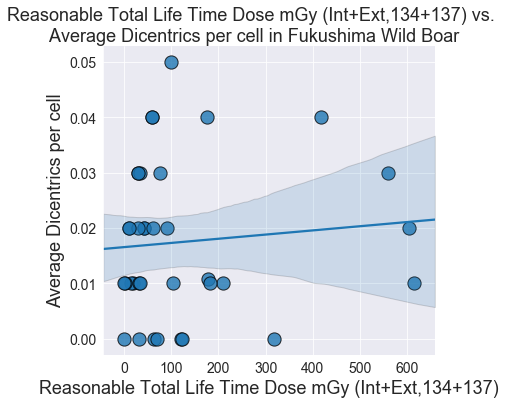

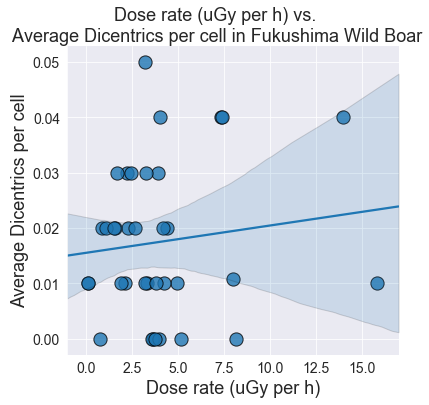

In [147]:
for col in dose_types:
    f_tm.linear_regression_graphs_between_variables(x=col, y='Average Dicentrics per cell', data=merge_dicentrics_dose)

## Statistics

In [58]:
merge_dicentrics_dose['encoded sex'] = merge_dicentrics_dose['Sex'].apply(lambda row: f_tm.encode_sex(row))

In [59]:
y = merge_dicentrics_dose['Average Dicentrics per cell'].values.reshape(-1, 1)
y_name = 'Avg Dicentrics/cell'

f_tm.linear_regression_scores_X_y(merge_dicentrics_dose, y, y_name, dose_types)

OLS | ['INTERNAL Life time dose, mGy 134+137'] vs. Avg Dicentrics/cell --> R2: 0.0173
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)'] vs. Avg Dicentrics/cell --> R2: 0.0801
OLS | ['INTERNAL Life time dose, mGy 134+137', 'Age (months)', 'encoded sex'] vs. Avg Dicentrics/cell --> R2: 0.0834

OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)'] vs. Avg Dicentrics/cell --> R2: 0.0109
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)'] vs. Avg Dicentrics/cell --> R2: 0.0110
OLS | ['EXTERNAL Dose Reasonable Life Time, mGy (134+137)', 'Age (months)', 'encoded sex'] vs. Avg Dicentrics/cell --> R2: 0.0458

OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'] vs. Avg Dicentrics/cell --> R2: 0.0085
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)'] vs. Avg Dicentrics/cell --> R2: 0.0085
OLS | ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)', 'Age (months)', 'encoded sex'] vs. Avg Dicentrics/cell --> R2: 

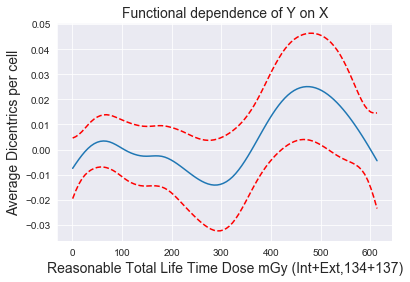

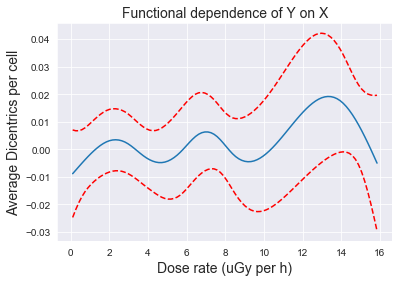

In [130]:
for dose in ['Reasonable Total Life Time Dose mGy (Int+Ext,134+137)',
             'Dose rate (uGy per h)']:
    
    features = [dose]
    target = 'Average Dicentrics per cell'
    f_tm.fit_gam_plot_dependencies(df=merge_dicentrics_dose, features=features, target=target,
                              basis_1=s, summary=False)

# Misc data representations

(array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 <a list of 8 Text yticklabel objects>)

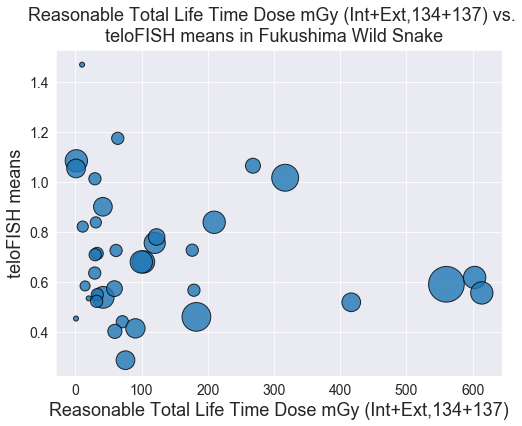

In [43]:
x = 'Reasonable Total Life Time Dose mGy (Int+Ext,134+137)'
y = 'teloFISH means'

plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=x, y=y, s=merge_kelly_teloFISH_dose['Age (months)'] * 25, alpha=0.8, 
                     data=merge_kelly_teloFISH_dose, 
                     linewidth=1,
                     edgecolor='black',
                    )

plt.suptitle(f'{x} vs.\n {y} in Fukushima Wild Snake', fontsize=18)
# plt.subplots_adjust(top=.85)

plt.xlabel(x, fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel(y, fontsize=18)
plt.yticks(fontsize=14)